## Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
from prettytable import PrettyTable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import json
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## ResNet Architecture:

In [6]:
# N:    residual layer (default: 4)
# B_i:  residual block in layer i (default: 2)
# C_1:  channel in layer 1 (default: 64)
# F_i:  filter in residual conv (default: 3)
# K_i:  filter in connection conv (default: 1)
# P:    average pooling size (default: 1)


class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


def convNxN(
        C_in,
        C_out,
        F,
        stride=1,
        groups=1,
        dilation=1,
        padding=1
) -> nn.Conv2d:
    """NxN convolution with padding"""
    return nn.Conv2d(C_in, C_out, kernel_size=F, stride=stride,
                     padding=padding, groups=groups, bias=False, dilation=dilation)


class ResBlock(nn.Module):
    def __init__(
            self,
            C_in,
            C_out,
            F,
            stride=1,
            groups=1,
            dilation=1,
            base_width=64,
            downsample=None,
            norm_layer=nn.BatchNorm2d
    ) -> None:
        super(ResBlock, self).__init__()
        if groups != 1:
            raise ValueError('BasicBlock only supports groups=1')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = convNxN(C_in=C_in, C_out=C_out, F=F, stride=stride, padding=(F - 1) // 2)
        self.bn1 = norm_layer(C_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = convNxN(C_in=C_out, C_out=C_out, F=F, stride=1, padding=(F - 1) // 2)
        self.bn2 = norm_layer(C_out)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
            self,
            C_1,
            N=4,
            F=[3, 3, 3, 3],
            B=[2, 2, 2, 2],
            K=[1, 1, 1, 1],
            P=1,
            num_classes=10,
            groups=1,
            width_per_group=64,
            norm_layer=nn.BatchNorm2d,
            D_P=0.,
            D_S=0,
            D_F=0.
    ) -> None:
        super(ResNet, self).__init__()
        self._norm_layer = norm_layer
        self.inplanes = C_1
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        # Input Layer
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=F[0], stride=2, padding=(F[0] - 1) // 2, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(self.inplanes, self.inplanes,
                                       K[0], F[0], B[0], dropout_prob=D_P, dropout_size=D_S)
        layer2 = []
        for i in range(N - 1):
            layer2.append(self._make_layer(self.inplanes * (2 ** i),
                                           self.inplanes * (2 ** (i + 1)),
                                           K[i], F[i], B[i], stride=2,
                                           dropout_prob=D_P, dropout_size=D_S))
        self.layer2 = nn.Sequential(*layer2)
        self.avgpool = nn.AdaptiveAvgPool2d((P, P))
        final_input = int(self.inplanes * (2 ** (N - 1)) * (P ** 2))
        if D_F > 0.:
            self.fc = nn.Sequential(
                nn.Dropout(D_F),
                nn.Linear(final_input, num_classes),
            )
        else:
            self.fc = nn.Linear(final_input, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, inplanes, planes, K, F, blocks, dropout_prob=0, dropout_size=0, stride=1):
        if inplanes == planes:
            downsample = None
        else:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=K, stride=stride, padding=(K - 1) // 2, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(ResBlock(inplanes, planes, F, stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResBlock(planes, planes, F, downsample=None))
        if dropout_prob > 0:
            layers.append(DropBlock2D(dropout_prob, dropout_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        for layer in self.layer2:
            x = layer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        self.rep = x
        x = self.fc(x)

        return x

## Hyperparameter setting

## Hyperparameters Experiment

## Dataset

In [16]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

hp = {
        'N': 2,
        'C_1': 128,
        'P': 1,
        'B': [3, 3],
        'F': [3, 3],
        'K': [3, 3]
    }
net = ResNet(**hp)
net = net.cuda()
net.load_state_dict(torch.load("{_N__ 2, _C_1__ 128, _P__ 1, _B__ [3, 3], _F__ [3, 3], _K__ [3, 3], _D_P__ 0.0, _D_S__ 0, _D_F__ 0.0}.pt"))

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
training_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=256, shuffle=True,
        num_workers=0, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=0, pin_memory=True)


total = {c: 0 for c in classes}
correct = {c: 0 for c in classes}
with torch.no_grad():
    for test_data in validation_loader:
        inputs, labels = test_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        for i, c in enumerate(classes):
            total[c] += (labels == i).sum().item()
            correct[c] += (predicted[labels == i] == labels[labels == i]).sum().item()


In [9]:
print({c: correct[c]/total[c] for c in classes})

{'plane': 0.905, 'car': 0.969, 'bird': 0.848, 'cat': 0.743, 'deer': 0.899, 'dog': 0.866, 'frog': 0.949, 'horse': 0.93, 'ship': 0.944, 'truck': 0.923}


## Training and Test Error

               cat                cat                cat                cat                dog


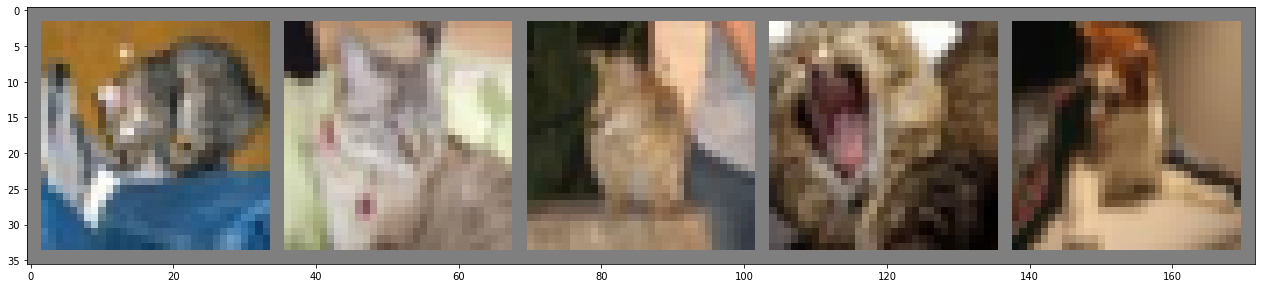

In [11]:
# get some random training images
dataiter = iter(validation_loader)
images, labels = dataiter.next()
plt.figure(figsize=(22,10)) 

outputs = net(images.cuda())
_, predicted = torch.max(outputs.data, 1)

# show images
imshow(torchvision.utils.make_grid(images[labels==3][0:5,:,:]))
# print labels
# print(' '.join('%18s' % classes[labels[labels==3][j]] for j in range(5)))
print(' '.join('%18s' % classes[predicted[labels==3][j].item()] for j in range(5)))

              deer               deer               ship               deer               deer


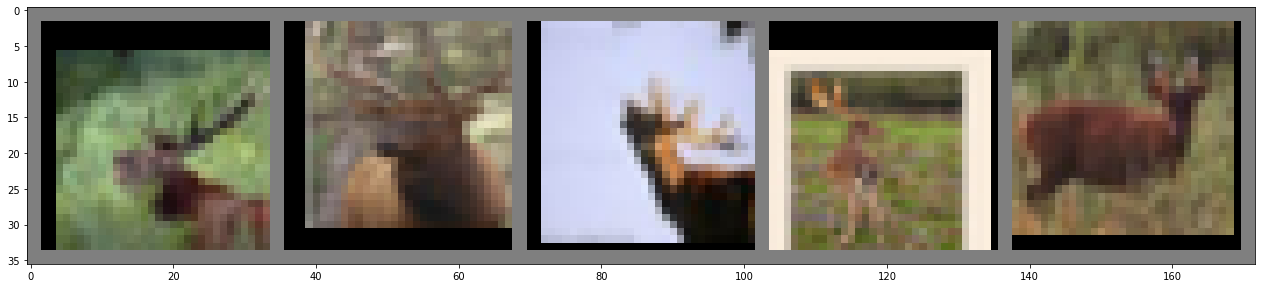

In [31]:
# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()
plt.figure(figsize=(22,10)) 

outputs = net(images.cuda())
_, predicted = torch.max(outputs.data, 1)

# show images
imshow(torchvision.utils.make_grid(images[labels==4][0:5,:,:]))
# print labels
# print(' '.join('%18s' % classes[labels[labels==3][j]] for j in range(5)))
print(' '.join('%18s' % classes[predicted[labels==4][j].item()] for j in range(5)))

tensor([4.1267e-08, 1.1880e-05, 1.3892e-05, 6.5726e-01, 3.0779e-07, 1.3441e-01,
        2.0831e-01, 1.0069e-07, 2.3798e-10, 1.8249e-07], device='cuda:0',
       grad_fn=<UnbindBackward0>)


AssertionError: 

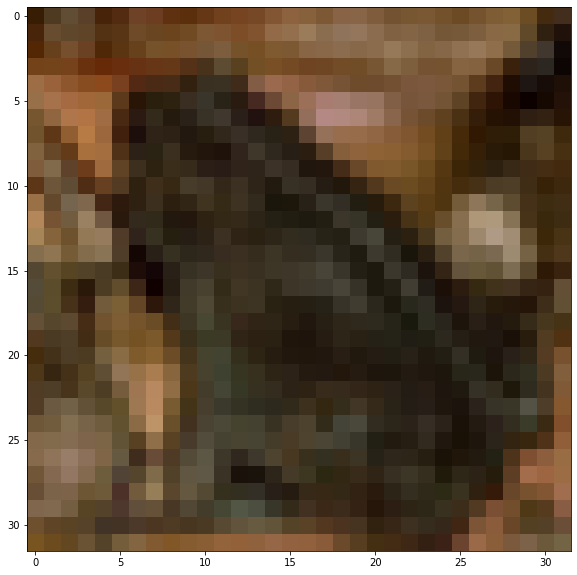

In [16]:
# get some random training images
dataiter = iter(validation_loader)
images, labels = dataiter.next()
plt.figure(figsize=(22,10)) 

outputs = net(images.cuda()).softmax(dim=-1)
_, predicted = torch.max(outputs.data, 1)

for out, pred, img, label in zip(outputs, predicted, images, labels):
    if pred != label:
        # show images
        imshow(torchvision.utils.make_grid(img))
        print(out)
        assert 0 == 1

In [28]:
validation_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=100, shuffle=False,
        num_workers=0, pin_memory=True)

reps = []
label = []
with torch.no_grad():
    for i, test_data in enumerate(validation_loader):
        if i == 20:
            break
        inputs, labels = test_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        reps.append(net.rep.data.detach().cpu().clone())
        label.extend(labels.tolist())
reps = torch.cat(reps, dim=0).numpy()
label = np.asarray(label)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.028058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.493225
[t-SNE] KL divergence after 1000 iterations: 1.166057


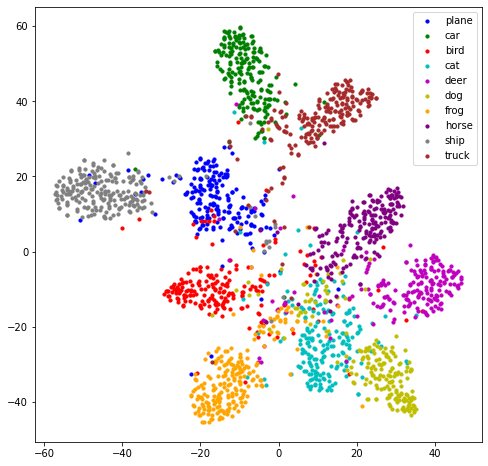

In [30]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple', 'grey', 'brown']
plt.figure(figsize=(8, 8))
tsne = TSNE(n_components=2, verbose=1, random_state=42, n_jobs=8)
original = tsne.fit_transform(reps)
for i in range(10):
    plt.scatter(original[label == i, 0], original[label == i, 1], c=colors[i], s=10, label=classes[i])
plt.legend()